### Basic Data Viz

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_pickle("../data/2017_US_Networks/all_features.pkl")

In [14]:
df.forman_curvature = df.forman_curvature.apply(list)
df["forman_mean"] = df.forman_curvature.apply(np.mean)
df["forman_mean_log"] = df.forman_mean.apply(np.log)
df["ollivier_mean"] = df["OR_0"].apply(np.mean)
df = df.query("total_mortality != -88888 and non_hmo_mortality != -88888 ").copy()

In [15]:
df.columns.values

array(['hsanum', 'region', 'state', 'medicare_enrollment',
       'total_mortality', 'non_hmo_mortality', 'forman_curvature',
       'n_nodes', 'n_edges', 'density', 'assortativity',
       'average_degrees', 'clustering_coefficients',
       'node_connectivities', 'degree_correlations',
       'obd_overall_diab_bloodlip', 'obd_nonblk_diab_bloodlip',
       'obd_blk_diab_bloodlip', 'obd_blk_diab_eye',
       'obd_overall_diab_eye', 'obd_nonblk_diab_eye',
       'obd_overall_diab_hgb', 'obd_blk_diab_hgb', 'obd_nonblk_diab_hgb',
       'obd_overall_mam_mam6769', 'obd_nonblk_mam_mam6769',
       'obd_blk_mam_mam6769', 'obd_nonblk_ptbjune_amcare2',
       'obd_blk_ptbjune_amcare2', 'obd_overall_ptbjune_amcare2',
       'oe_overall_diab_bloodlip', 'oe_nonblk_diab_bloodlip',
       'oe_blk_diab_bloodlip', 'oe_blk_diab_eye', 'oe_overall_diab_eye',
       'oe_nonblk_diab_eye', 'oe_overall_diab_hgb', 'oe_blk_diab_hgb',
       'oe_nonblk_diab_hgb', 'oe_overall_mam_mam6769',
       'oe_nonblk_mam

In [4]:
df.columns.values[:10]

array(['hsanum', 'region', 'state', 'medicare_enrollment',
       'total_mortality', 'non_hmo_mortality', 'forman_curvature',
       'n_nodes', 'n_edges', 'density'], dtype=object)

In [21]:
vars_ = [
 #'medicare_enrollment',
 'total_mortality',
 'non_hmo_mortality',
 'race_total_pop',
 #'race_black_pop',
 #'hispanic_total_pop',
 #'hispanic_pop',
 #'median_hh_income',
 #'employment_pop',
 #'employment_unemployed_pop',
 #'education_pop',
 #'education_nohs_pop'
]

In [22]:
import matplotlib as mpl

In [7]:
cmap = mpl.colormaps["tab10"]

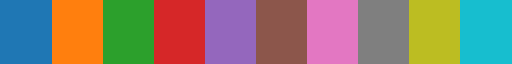

In [8]:
cmap

In [9]:
sorted_regions = sorted(df.region.unique(), key=lambda string: int(string.split()[1]))

In [10]:
def prettify(reg):
    return reg.replace(" ", "")

#### Note
In the following, all but the mortalities are scaled logarithmically, which makes it harder to interpret the plots (especially when axes are mixed). 
Beware that we are not looking at linear correlations here (except when examining mortalities on x and y).

In [65]:
labelsize = 18
ticksize = 16

### Top left (curvature result)
This replaces the planned ORC figure; we see that higher race population is associated with more negative curvature and larger medicare enrollment.
- x: race_total_pop
- y: forman_mean
- hue: region
- size: medicare_enrollment

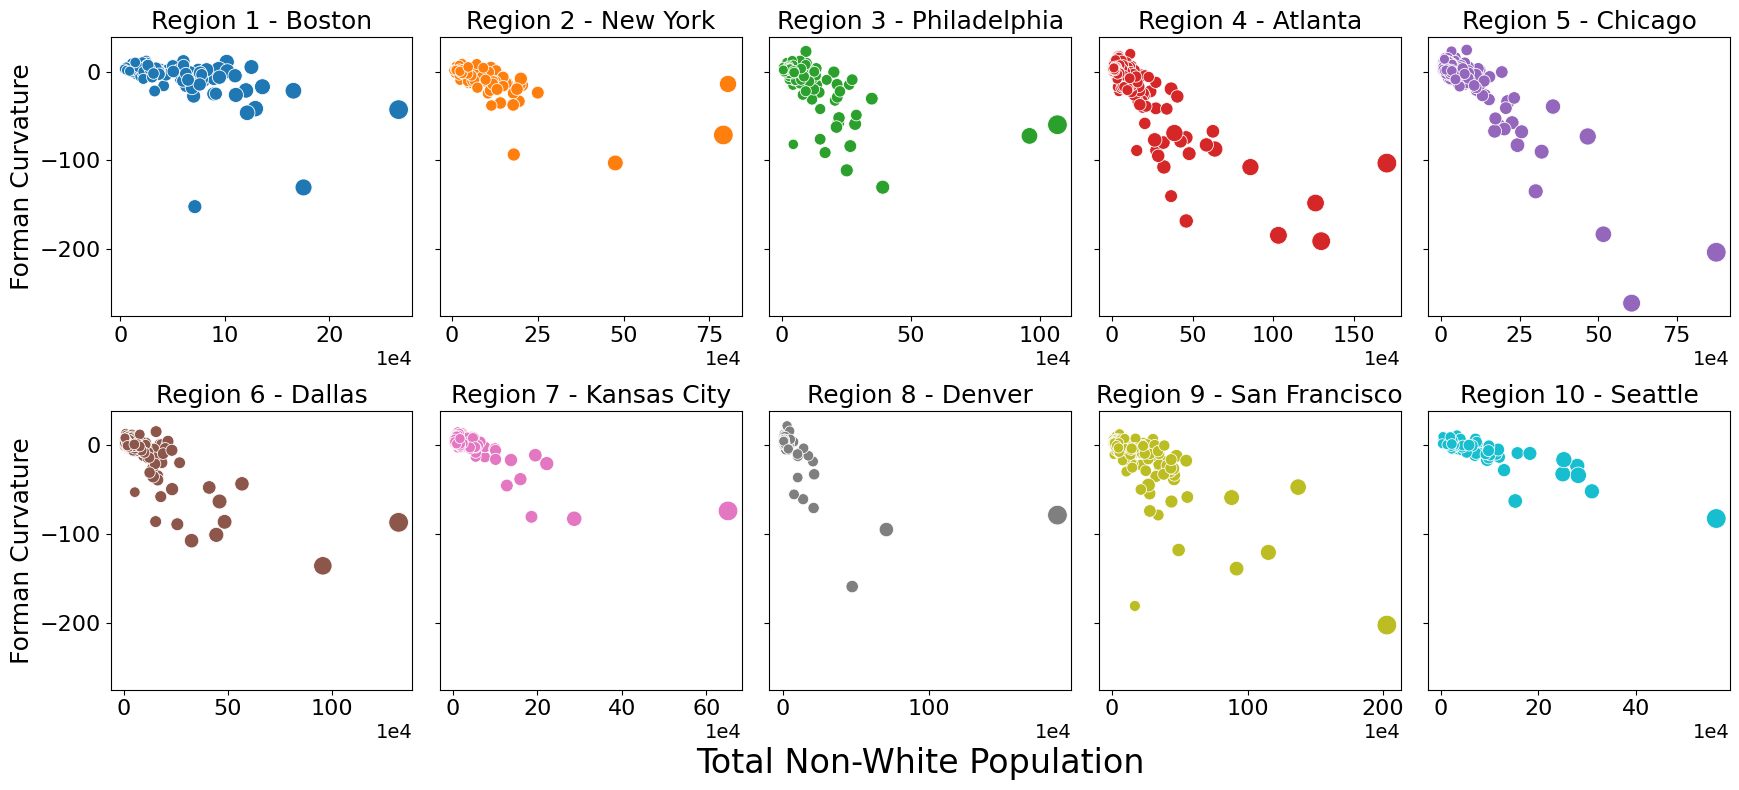

In [93]:
y_var = "forman_mean"
x_var = "race_total_pop"
fig, ax = plt.subplots(2,5,figsize=(1.75 * len(sorted_regions),4 * 2), sharey=True, sharex=False)

for idx,reg in enumerate(sorted_regions):
    x, y = divmod(idx,5)
    sns.scatterplot(df.query("region == @reg"), ax=ax[x,y], x=x_var, y=y_var, 
                    hue="region", palette=[cmap(idx/len(sorted_regions))], 
                    size="medicare_enrollment",sizes=(50,200),
                   legend=False)
    ax[x,y].set_title(reg, fontsize=labelsize)
    ax[x,y].set_xlabel("")
    ax[x,y].tick_params(axis='both', which='major', labelsize=ticksize)
    ax[x,y].ticklabel_format(style="sci", axis="x", scilimits=(4,4))
    ax[x,y].xaxis.offsetText.set_fontsize(ticksize - 2)
for idx in [0,1]:
    ax[idx,0].set_ylabel("Forman Curvature", fontsize=labelsize)
ax[1,2].set_xlabel("Total Non-White Population", fontsize=labelsize + 6)
ax[1,2].xaxis.labelpad = 20
plt.tight_layout()
plt.savefig(f"../figures/all-regions_{x_var}-vs-{y_var}.pdf", bbox_inches="tight", transparent=True)

In [ ]:
y_var = "forman_mean"
for idx,reg in enumerate(sorted_regions):
    g = sns.pairplot(data=df.query("region == @reg"), y_vars=[y_var], x_vars=vars_, hue="region", palette=[cmap(idx/len(sorted_regions))])
    # for i in [0,3,4,5,6,7,8,9,10,11]:
        # g.axes[0,i].set_xscale("log")
    plt.savefig(f"../figures/{prettify(reg)}_{y_var}_vs_mortality-statistics.pdf", bbox_inches="tight", transparent=True)

In [ ]:
for idx,reg in enumerate(sorted_regions):
    g = sns.pairplot(data=df.query("region == @reg"), y_vars=vars_, x_vars=vars_, hue="region", palette=[cmap(idx/len(sorted_regions))])
    for i in [0,3,4,5,6,7,8,9,10,11]:
        for j in range(11):
            g.axes[j,i].set_xscale("log")
            g.axes[i,j].set_yscale("log")
    plt.savefig(f"../figures/{prettify(reg)}_mortality-statistics.pdf", bbox_inches="tight", transparent=True)

### Grouping variables

In [87]:
group_prefixes = ["oear", "obd", "cr", "ar", "ptl", "oecr", "oe", "expa", "exp"]
columns_dict = {p:list() for p in group_prefixes}
other_columns = list()
for x in df.columns.values:
    prefix, rest = x.split('_', 1) if "_" in x else (x, "")
    if prefix in group_prefixes:
        columns_dict[prefix].append(x)
    else:
        other_columns.append(x)

In [88]:
other_columns

['hsanum',
 'region',
 'state',
 'medicare_enrollment',
 'total_mortality',
 'non_hmo_mortality',
 'forman_curvature',
 'n_nodes',
 'n_edges',
 'density',
 'assortativity',
 'average_degrees',
 'clustering_coefficients',
 'node_connectivities',
 'degree_correlations',
 'race_total_pop',
 'race_black_pop',
 'hispanic_total_pop',
 'hispanic_pop',
 'median_hh_income',
 'employment_pop',
 'employment_unemployed_pop',
 'education_pop',
 'education_nohs_pop',
 'forman_mean',
 'forman_mean_log']

In [89]:
columns_dict

{'oear': ['oear_pt_asr_ami_anyac',
  'oear_pt_asr_ami_aoervis',
  'oear_pt_asr_ami_mdac',
  'oear_pt_asr_ami_readmit',
  'oear_pt_asr_chf_anyac',
  'oear_pt_asr_chf_aoervis',
  'oear_pt_asr_chf_mdac',
  'oear_pt_asr_chf_readmit',
  'oear_pt_asr_med_anyac',
  'oear_pt_asr_med_aoervis',
  'oear_pt_asr_med_mdac',
  'oear_pt_asr_med_readmit',
  'oear_pt_asr_pn_anyac',
  'oear_pt_asr_pn_aoervis',
  'oear_pt_asr_pn_mdac',
  'oear_pt_asr_pn_readmit',
  'oear_pt_asr_sur_aoervis',
  'oear_pt_asr_sur_mdac',
  'oear_pt_asr_sur_readmit'],
 'obd': ['obd_overall_diab_bloodlip',
  'obd_nonblk_diab_bloodlip',
  'obd_blk_diab_bloodlip',
  'obd_blk_diab_eye',
  'obd_overall_diab_eye',
  'obd_nonblk_diab_eye',
  'obd_overall_diab_hgb',
  'obd_blk_diab_hgb',
  'obd_nonblk_diab_hgb',
  'obd_overall_mam_mam6769',
  'obd_nonblk_mam_mam6769',
  'obd_blk_mam_mam6769',
  'obd_nonblk_ptbjune_amcare2',
  'obd_blk_ptbjune_amcare2',
  'obd_overall_ptbjune_amcare2',
  'obd_pt_asr_ami_anyac',
  'obd_pt_asr_ami_aoervi

## Plotting CHOC Network

In [191]:
# CHOC Network properties
choc_hsa = 5218
choc_network = "../data/2017_US_Networks/santa_ana_graph.pkl"

with open(choc_network, "rb") as f:
    G = pickle.load(f)

#choc_curvature = df.query("hsanum == @choc_hsa").OR_0.values[0]

In [96]:
pos = nx.circular_layout(G)


degrees = G.degree() #Dict with Node ID, Degree
centrality = nx.degree_centrality(G)
cent_sizes = [centrality[node] * 500 for node in G.nodes()] #Scale Visually



nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])


# Max
weights = [max(G[u][v]['a2b'],G[u][v]['b2a'])/20 for u,v in G.edges()]

In [249]:
df.query("hsanum == @choc_hsa").OR_0.iloc[0].min(), df.query("hsanum == @choc_hsa").OR_0.iloc[0].max()

(-1.295918367346939, 0.7536764705882355)

### Network Drawings of Santa Ana
Comments CC: 
- I like the Kamada-Kawai Layout (layout 2) best because it seems to show interesting referral motifs
- I put ORC on the edges here but am honestly unsure if the ordering I get from the DF matches the edge ordering (did you check?)
- I use a diverging color palette and centered it on 0 

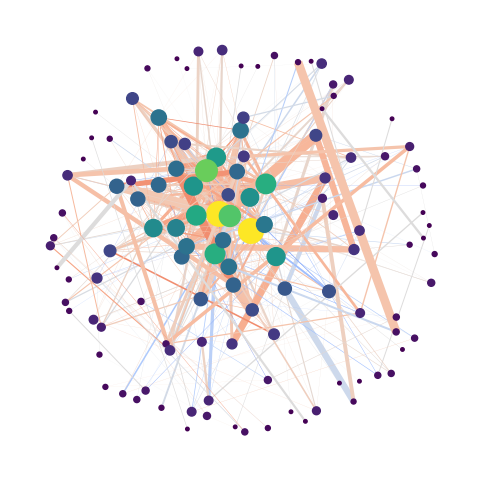

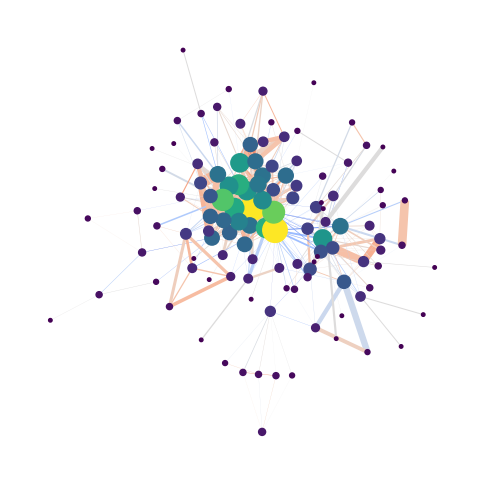

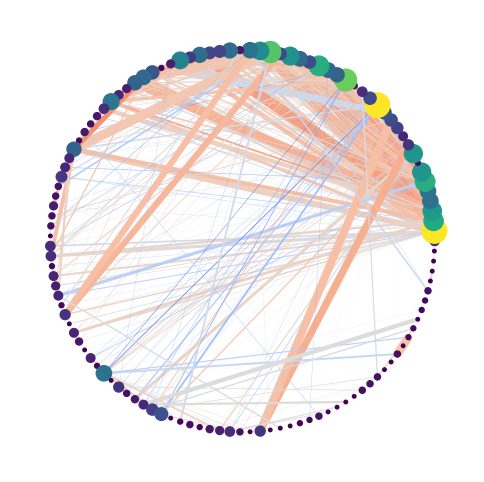

In [251]:
sG = G
sG_centrality = nx.degree_centrality(sG)
sG_cent_sizes = [sG_centrality[node] * 750 for node in sG.nodes()] #Scale Visually
sG_n_color = np.asarray([degrees[n] for n in sG.nodes()])
pos1 = nx.fruchterman_reingold_layout(sG, k=1.2, seed=42)
pos2 = nx.kamada_kawai_layout(sG, scale=1000)
pos3 = nx.circular_layout(sG)
for idx,pos in enumerate([pos1, pos2, pos3]):
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    nx.draw_networkx_nodes(sG, 
            pos=pos, node_size=sG_cent_sizes,node_color=sG_n_color,
                          )
    sG_weights = [max(G[u][v]['a2b'],G[u][v]['b2a'])/20 for u,v in sG.edges()]
    MMS = MinMaxScaler()
    nx.draw_networkx_edges(sG, pos=pos, width=sG_weights, edge_color=df.query("hsanum == @choc_hsa").OR_0.iloc[0], 
                           edge_cmap=plt.cm.coolwarm, edge_vmax=1.3, edge_vmin=-1.3
                          )
    ax.set_axis_off()
    plt.savefig(f"../figures/santa-ana_layout-{idx}.pdf", bbox_inches="tight", transparent=True)

## Curvature Distributions

In [40]:
region_states = {
    "Region 1 - Boston": ["CT", "ME", "MA", "NH", "RI", "VT"],
    "Region 10 - Seattle": ["AK", "ID", "OR", "WA"],
    "Region 2 - New York": ["NJ", "NY", "PR", "VI"],
    "Region 3 - Philadelphia": ["DE", "DC", "MD", "PA", "VA", "WV"],
    "Region 4 - Atlanta": ["AL", "FL", "GA", "KY", "MS", "NC", "SC", "TN"],
    "Region 5 - Chicago": ["IL", "IN", "MI", "MN", "OH", "WI"],
    "Region 6 - Dallas": ["AR", "LA", "NM", "OK", "TX"],
    "Region 7 - Kansas City": ["IA", "KS", "MO", "NE"],
    "Region 8 - Denver": ["CO", "MT", "ND", "SD", "UT", "WY"],
    "Region 9 - San Francisco": ["AS", "AZ", "CA", "MP", "FM", "GU", "HI", "MH", "NV", "PW"]
}


# Sort states within each region
for region, states in region_states.items():
    region_states[region] = sorted(states)

# Concatenate sorted states into a single list
ordered_states = []
for region in sorted(region_states.keys()):
    ordered_states.extend(region_states[region])

In [41]:
trimmed_df = df[["hsanum", "region", "state","OR_0",]]

In [42]:
trimmed_df = trimmed_df.explode('OR_0')

trimmed_df.head()

,hsanum,region,state,OR_0
0,4002,Region 6 - Dallas,AR,0.0
0,4002,Region 6 - Dallas,AR,0.1
0,4002,Region 6 - Dallas,AR,0.0
0,4002,Region 6 - Dallas,AR,-0.6
0,4002,Region 6 - Dallas,AR,0.1


In [43]:
melted_df = pd.melt(trimmed_df, id_vars=['hsanum','state', 'region'],
                    var_name='Curvature Type',value_name="ORC")

melted_df.head()

,hsanum,state,region,Curvature Type,ORC
0,4002,AR,Region 6 - Dallas,OR_0,0.0
1,4002,AR,Region 6 - Dallas,OR_0,0.1
2,4002,AR,Region 6 - Dallas,OR_0,0.0
3,4002,AR,Region 6 - Dallas,OR_0,-0.6
4,4002,AR,Region 6 - Dallas,OR_0,0.1


In [37]:
region_order = df["region"].unique()
region_numbers = [int(region.split(' - ')[0].split(' ')[-1]) for region in region_order]
sorted_regions_array = [region for _, region in sorted(zip(region_numbers, region_order))]

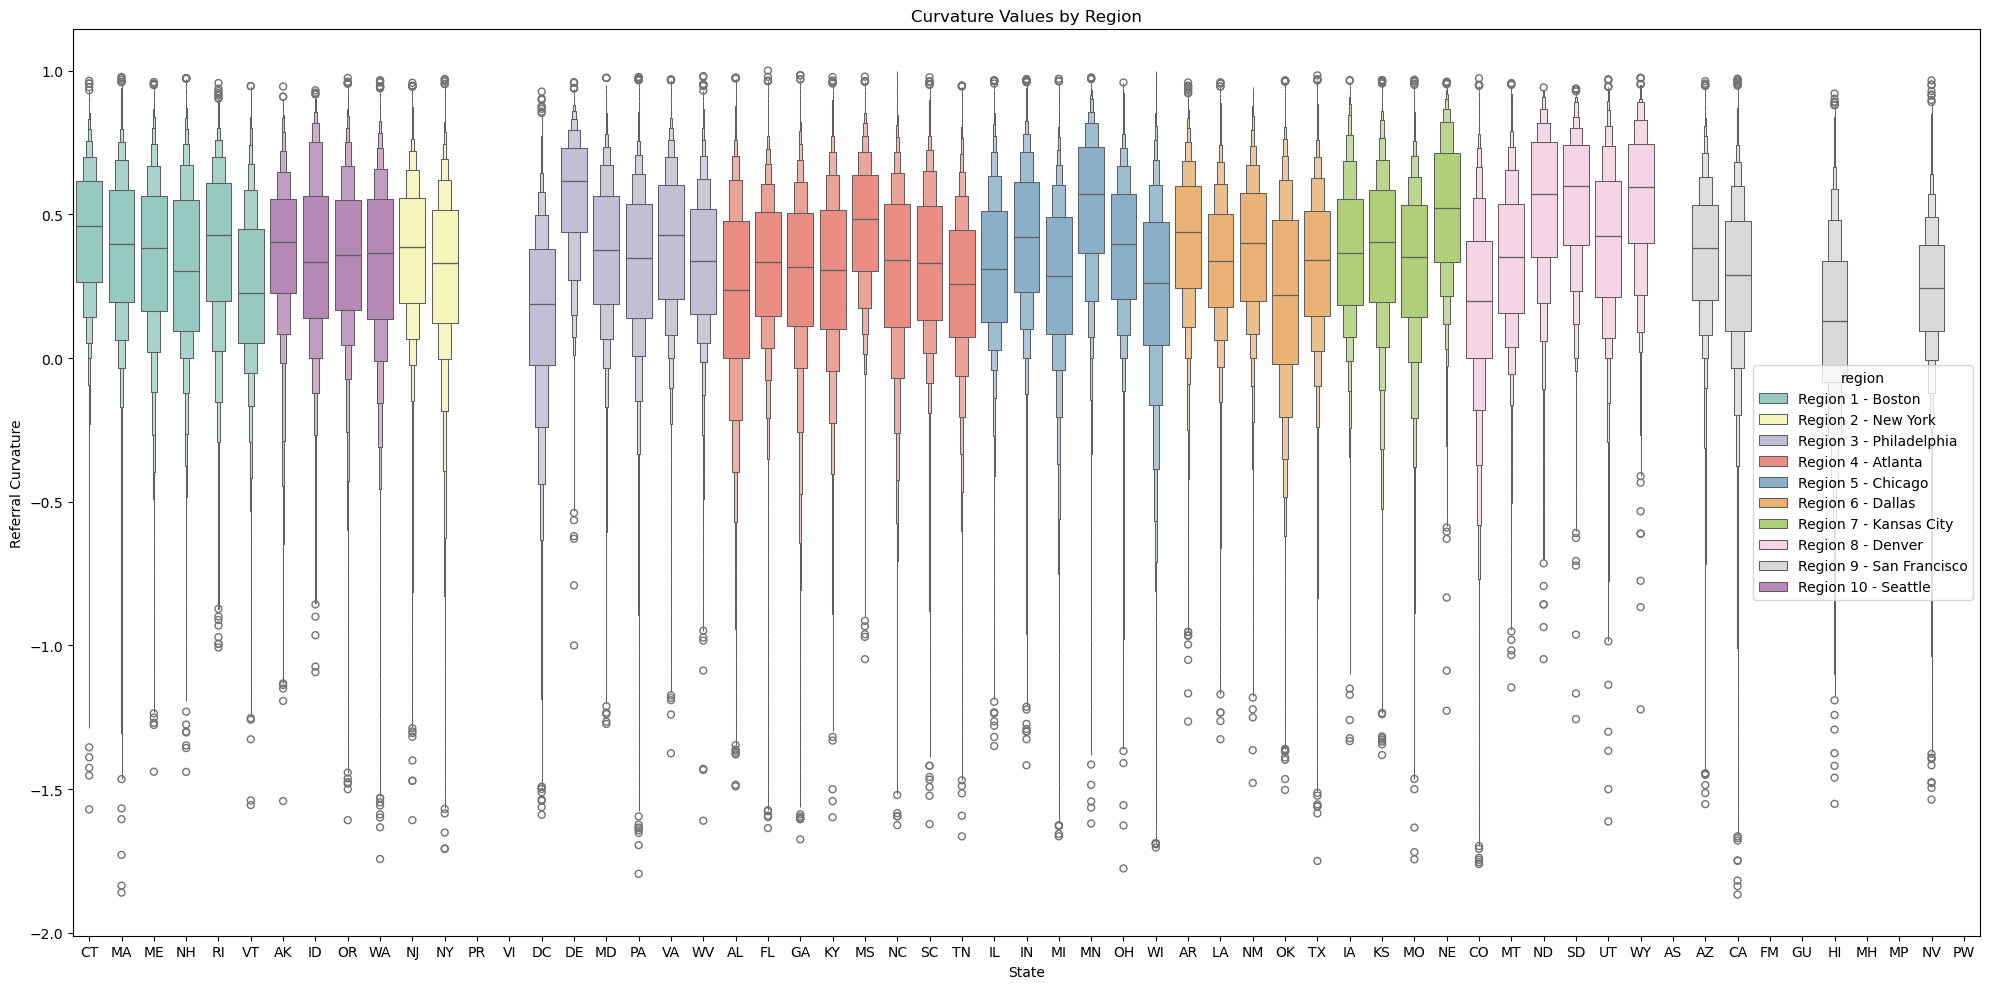

In [38]:
plt.figure(figsize=(20, 10))
sns.boxenplot(x='state', y='ORC', hue="region", data=melted_df, palette="Set3",hue_order=sorted_regions_array,order=ordered_states,)
plt.title('Curvature Values by Region')
plt.xlabel('State')
plt.ylabel('Referral Curvature')
plt.tight_layout()
plt.show()

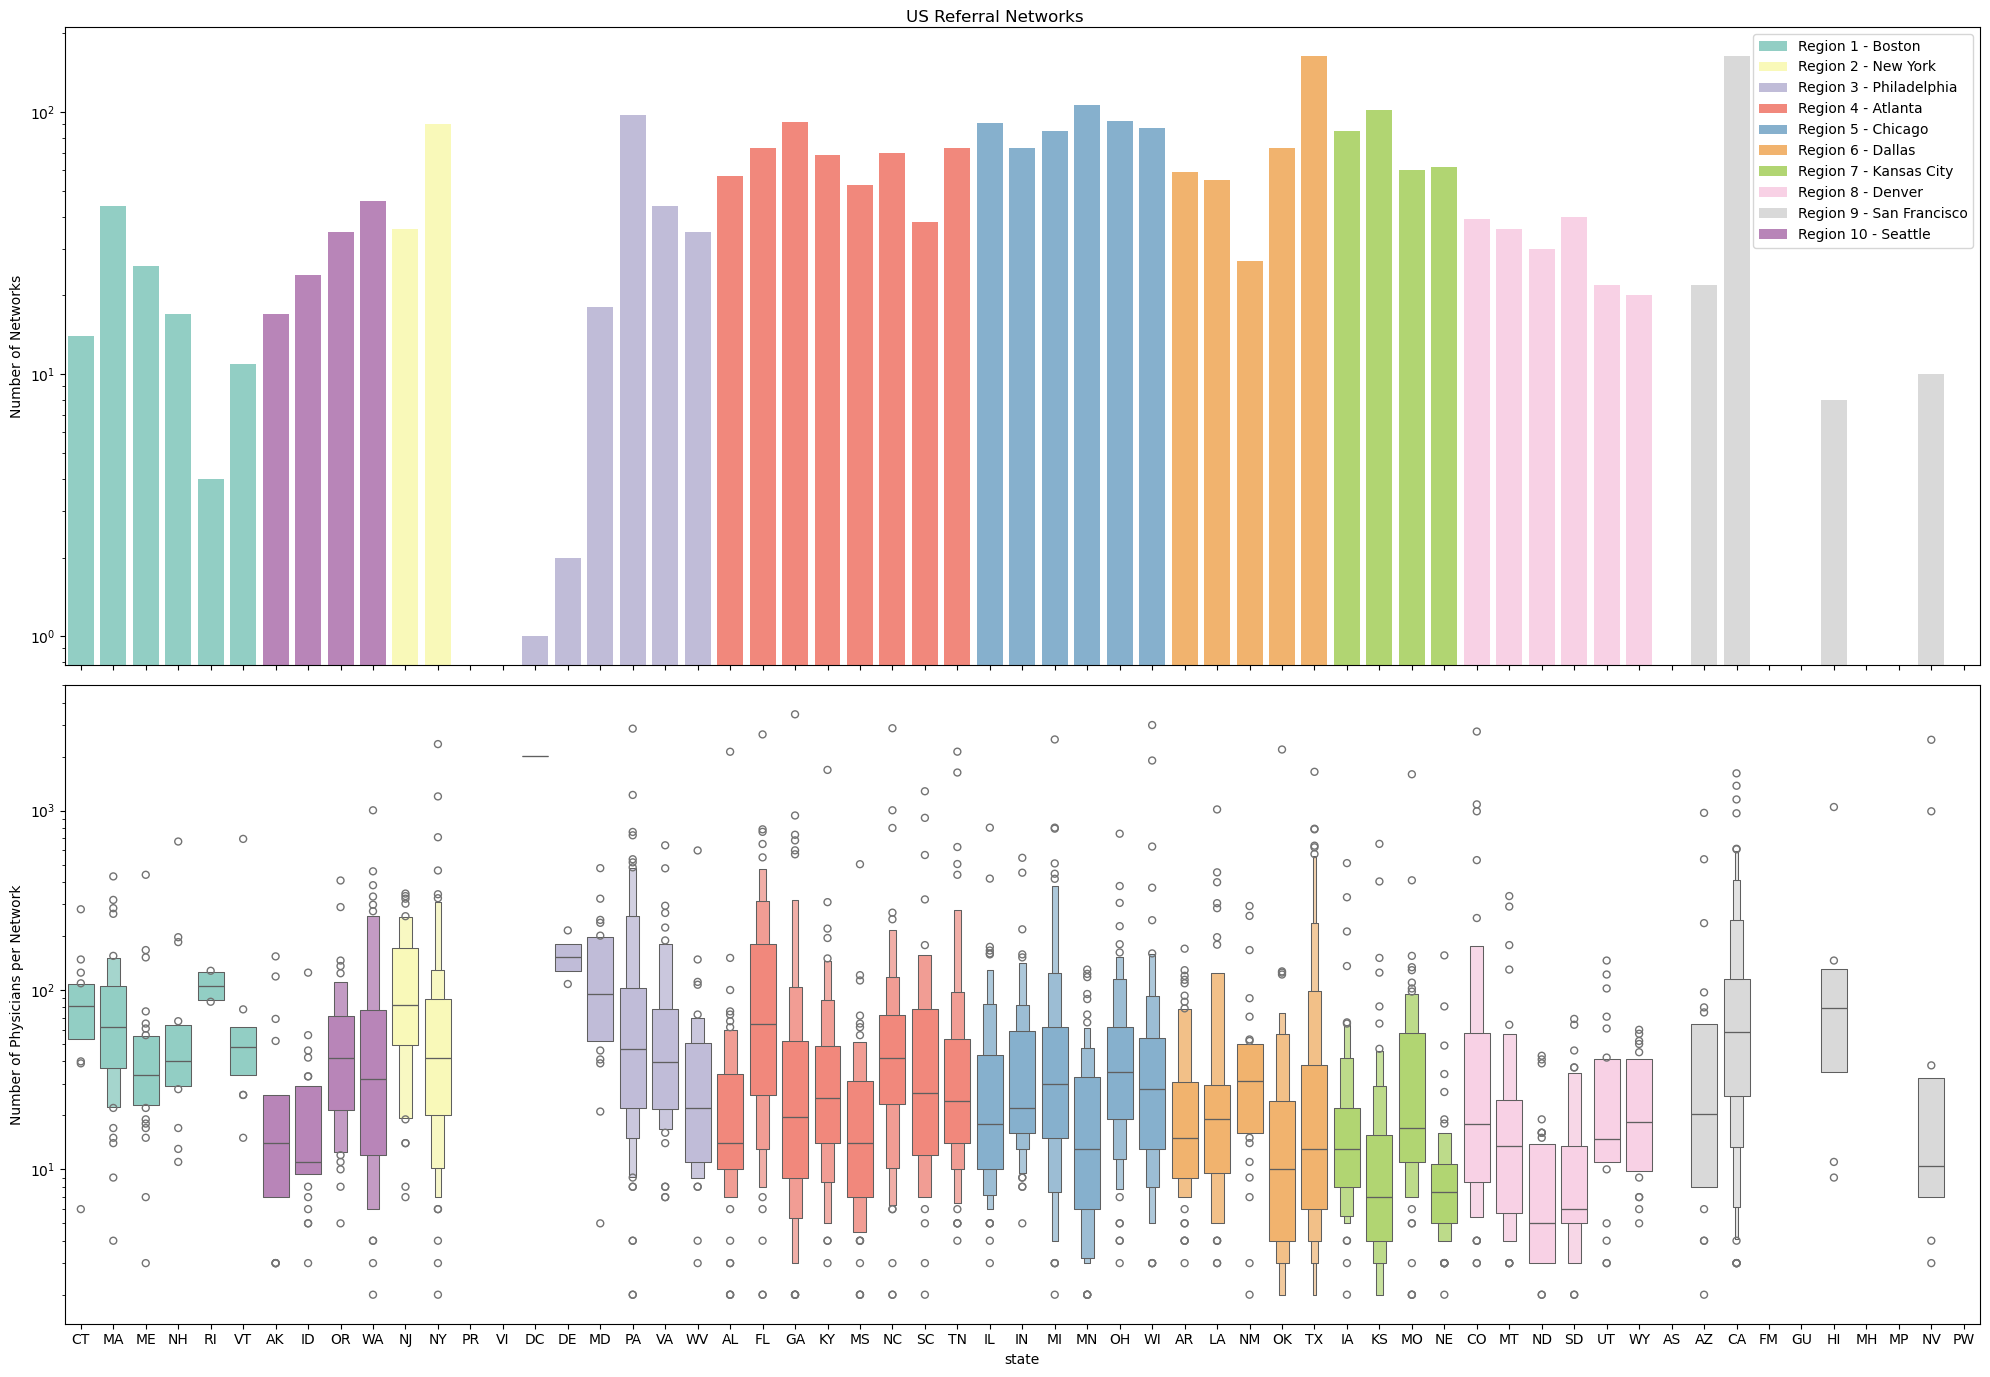

In [46]:
# Set up the figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14), sharex=True)

# Plot 1: Countplot
sns.countplot(data=df, x="state", hue="region", hue_order=sorted_regions_array, order=ordered_states, palette="Set3", saturation=0.85, ax=ax1,)
ax1.set_ylabel('Number of Networks')
ax1.set_yscale('log')
ax1.legend(loc='upper right')  # 

# Plot 2: Boxenplot
sns.boxenplot(data=df, x="state", y="n_nodes", hue="region", hue_order=sorted_regions_array, order=ordered_states, palette="Set3", saturation=0.85, log_scale=True, ax=ax2)
ax2.set_ylabel('Number of Physicians per Network')
ax2.legend(loc='upper right')
ax2.get_legend().remove()

plt.suptitle("US Referral Networks")
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [45]:
df.columns

Index(['hsanum', 'region', 'state', 'medicare_enrollment', 'total_mortality',
       'non_hmo_mortality', 'forman_curvature', 'n_nodes', 'n_edges',
       'density',
       ...
       'race_total_pop', 'race_black_pop', 'hispanic_total_pop',
       'hispanic_pop', 'median_hh_income', 'employment_pop',
       'employment_unemployed_pop', 'education_pop', 'education_nohs_pop',
       'OR_0'],
      dtype='object', length=294)